In [1]:
import warnings
warnings.filterwarnings(action='ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 폰트 설정 방법 2
import matplotlib as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()

font_location = r'Fonts\H2HDRM.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error


### 추정매출 데이터 불러오기

In [2]:
rev_2020 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출).csv', encoding = 'cp949' )
rev_2019 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2019.csv', encoding = 'cp949' )
rev_2018 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2018.csv', encoding = 'cp949' )
rev_2017 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2017.csv', encoding = 'cp949' )
rev_2016 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2016.csv', encoding = 'cp949' )
rev_2015 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2015.csv', encoding = 'cp949' )

In [9]:
rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6415600,169,...,0,63,106,0,10,139,10,5,5,8
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,10400909742,5270,...,35,2458,2812,0,0,245,1441,1722,1862,5
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66506,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,257814129,27092,...,1205,10426,14742,234,4316,7089,6188,4351,2989,4
66507,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,156728306,3589,...,33,1281,2014,5,1361,1116,331,325,157,3
66508,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,55484866,1272,...,241,622,508,0,134,245,275,314,162,3
66509,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,25767161,1413,...,0,592,694,145,368,240,368,96,69,1


### 내가 관심있는 상권을 검색

In [99]:
gangnam_rev_2020 = rev_2020.groupby(['상권_코드']).get_group((1001496))
gangnam_rev_2019 = rev_2019.groupby(['상권_코드']).get_group((1001496))
gangnam_rev_2018 = rev_2018.groupby(['상권_코드']).get_group((1001496))
gangnam_rev_2017 = rev_2017.groupby(['상권_코드']).get_group((1001496))
gangnam_rev_2016 = rev_2016.groupby(['상권_코드']).get_group((1001496))
gangnam_rev_2015 = rev_2015.groupby(['상권_코드']).get_group((1001496))

gangnam_rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6415600,169,...,0,63,106,0,10,139,10,5,5,8
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,10400909742,5270,...,35,2458,2812,0,0,245,1441,1722,1862,5
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33297,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100005,제과점,2411081120,199927,...,3608,56592,122241,1828,52191,59126,32649,21658,11379,18
33298,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100004,양식음식점,2088803850,50291,...,1988,17593,26562,314,11875,16440,9668,3819,2039,42
33299,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100003,일식음식점,2794137730,123296,...,2473,43776,64359,1315,32832,36572,20427,10718,6268,20
33300,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100002,중식음식점,2440339835,65276,...,1952,25314,28930,364,15583,18680,9704,7024,2888,10


### 년도와 상권코드를 입력하면 입력한 상권 및 연도의 4분기 동안 공통된 서비즈 업종을 찾는다

### ( 누락된 서비스 업종은 제외한다 )

In [ ]:
def return_com_sc_by_year_and_ba(year,ba):
    if (year != 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,3,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,4,ba))['서비스_업종_코드_명'])
    
    if (year == 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])
    
    return common_sc

### 그리고나서 모든 연도와 비교하여 누락된 서비스 업종을 제외한다

In [13]:
common_sc_1001496 = set(return_com_sc_by_year_and_ba(2020,1001496)) &\
set(return_com_sc_by_year_and_ba(2019,1001496)) &\
set(return_com_sc_by_year_and_ba(2018,1001496)) &\
set(return_com_sc_by_year_and_ba(2017,1001496)) &\
set(return_com_sc_by_year_and_ba(2016,1001496)) &\
set(return_com_sc_by_year_and_ba(2015,1001496))

### 최종적으로 분석에 이용할 서비스 업종의 개수를 확인한다

In [15]:
len(common_sc_1001496)

32

### 위에서 구한 common_sc(공통 서비스 업종)으로 데이터를 필터링한다

In [94]:
# new_rev_2015~2020 에 대해서 공통 sc만 남기고 합침

gangnam_new_rev_2020 = gangnam_rev_2020.loc[gangnam_rev_2020['서비스_업종_코드_명'].isin(common_sc_1001496)]
gangnam_new_rev_2019 = gangnam_rev_2019.loc[gangnam_rev_2019['서비스_업종_코드_명'].isin(common_sc_1001496)]
gangnam_new_rev_2018 = gangnam_rev_2018.loc[gangnam_rev_2018['서비스_업종_코드_명'].isin(common_sc_1001496)]
gangnam_new_rev_2017 = gangnam_rev_2017.loc[gangnam_rev_2017['서비스_업종_코드_명'].isin(common_sc_1001496)]
gangnam_new_rev_2016 = gangnam_rev_2016.loc[gangnam_rev_2016['서비스_업종_코드_명'].isin(common_sc_1001496)]
gangnam_new_rev_2015 = gangnam_rev_2015.loc[gangnam_rev_2015['서비스_업종_코드_명'].isin(common_sc_1001496)]

In [62]:
# print(gangnam_rev_2020.shape)
# print(gangnam_new_rev_2020.shape)
gangnam_new_rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
5,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300026,완구,506304623,7512,...,0,4912,2600,249,2291,2347,2089,387,149,8
6,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300024,운동/경기용품,10213546282,35419,...,1376,18762,16339,555,10560,12107,5540,3479,2861,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33297,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100005,제과점,2411081120,199927,...,3608,56592,122241,1828,52191,59126,32649,21658,11379,18
33298,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100004,양식음식점,2088803850,50291,...,1988,17593,26562,314,11875,16440,9668,3819,2039,42
33299,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100003,일식음식점,2794137730,123296,...,2473,43776,64359,1315,32832,36572,20427,10718,6268,20
33300,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100002,중식음식점,2440339835,65276,...,1952,25314,28930,364,15583,18680,9704,7024,2888,10


### 필터링한 데이터를 합쳐서 하나의 큰 데이터로 만든다

In [29]:
gangnam_all_rev = new_rev_2020.append(gangnam_new_rev_2019, ignore_index=True)\
.append(gangnam_new_rev_2018, ignore_index=True)\
.append(gangnam_new_rev_2017, ignore_index=True)\
.append(gangnam_new_rev_2016, ignore_index=True)\
.append(gangnam_new_rev_2015, ignore_index=True)

gangnam_all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300026,완구,506304623,7512,...,0,4912,2600,249,2291,2347,2089,387,149,8
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300024,운동/경기용품,10213546282,35419,...,1376,18762,16339,555,10560,12107,5540,3479,2861,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS300016,안경,953225275,7646,...,273,2283,5146,109,2590,2477,1082,739,431,7
700,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200030,피부관리실,188056807,1524,...,155,574,765,3,258,572,223,176,108,3
701,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS100001,한식음식점,10517058701,409082,...,10405,146867,194812,6072,113240,113840,63022,31369,14135,42
702,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200007,치과의원,571691177,2416,...,27,1282,1134,3,486,668,474,474,311,5


### 쓸모없는 열은 제외한다.

In [34]:
gangnam_all_rev = gangnam_all_rev.drop(['상권_구분_코드_명','상권_코드_명','서비스_업종_코드'], axis=1)

In [36]:
# gangnam_all_rev.to_csv(r'gangnam_all_rev.csv', encoding = 'cp949')
# 다운로드해서 제대로 됐는지 확인하기 위함이었음

### 위 과정에서 인풋 데이터 준비는 1차적으로 끝났고, 이제 아웃풋 데이터를 준비한다

In [38]:
fr_2020 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2020_new.csv', encoding = 'cp949' )
fr_2019 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2019_new.csv', encoding = 'cp949' )
fr_2018 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2018_new.csv', encoding = 'cp949' )
fr_2017 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2017_new.csv', encoding = 'cp949' )
fr_2016 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2016_new.csv', encoding = 'cp949' )
fr_2015 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2015_new.csv', encoding = 'cp949' )

In [40]:
fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
0,0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,0
1,1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300042,주유소,0
2,2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300041,예술품,0
3,3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300040,재생용품 판매점,0
4,4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300038,자동차부품,0
...,...,...,...,...,...,...,...,...,...,...
184550,184550,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,0
184551,184551,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,0
184552,184552,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,0
184553,184553,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,0


In [57]:
gangnam_fr_2020 = fr_2020.groupby(['상권_코드']).get_group((1001496))[['폐업_률','서비스_업종_코드_명']]
gangnam_fr_2019 = fr_2019.groupby(['상권_코드']).get_group((1001496))[['폐업_률','서비스_업종_코드_명']]
gangnam_fr_2018 = fr_2018.groupby(['상권_코드']).get_group((1001496))[['폐업_률','서비스_업종_코드_명']]
gangnam_fr_2017 = fr_2017.groupby(['상권_코드']).get_group((1001496))[['폐업_률','서비스_업종_코드_명']]
gangnam_fr_2016 = fr_2016.groupby(['상권_코드']).get_group((1001496))[['폐업_률','서비스_업종_코드_명']]
gangnam_fr_2015 = fr_2015.groupby(['상권_코드']).get_group((1001496))[['폐업_률','서비스_업종_코드_명']]

gangnam_fr_2020


,폐업_률,서비스_업종_코드_명
0,0,전자상거래업
1,0,주유소
2,0,예술품
3,0,재생용품 판매점
4,0,자동차부품
...,...,...
92525,6,제과점
92526,10,양식음식점
92527,5,일식음식점
92528,0,중식음식점


### 각 연도의 공통된 서비스 업종을 찾는다

In [48]:
def fr_return_com_sc_by_year_and_ba(year,ba):
    if (year != 2020):
        common_sc = set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,3,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,4,ba))['서비스_업종_코드_명'])
    
    if (year == 2020):
        common_sc = set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])
    
    return common_sc

### 모든 연도에 공통된 서비스 업종을 찾고, 누락된 서비스 업종은 제외한다

In [49]:
fr_common_sc_1001496 = set(fr_return_com_sc_by_year_and_ba(2020,1001496)) &\
set(fr_return_com_sc_by_year_and_ba(2019,1001496)) &\
set(fr_return_com_sc_by_year_and_ba(2018,1001496)) &\
set(fr_return_com_sc_by_year_and_ba(2017,1001496)) &\
set(fr_return_com_sc_by_year_and_ba(2016,1001496)) &\
set(fr_return_com_sc_by_year_and_ba(2015,1001496))

In [51]:
print(len(common_sc_1001496))
print(len(fr_common_sc_1001496))

32
77


### 중요 : 인풋 데이터의 서비스업종과 아웃풋 데이터의 서비스 업종이 일치하는지 확인해야 한다

In [53]:
_common_sc = set(common_sc_1001496) & set(fr_common_sc_1001496)
len(_common_sc) # common_sc_1001496 이것이 공통 sc

32

In [98]:
gangnam_new_fr_2020 = gangnam_fr_2020.loc[gangnam_fr_2020['서비스_업종_코드_명'].isin(_common_sc)]
gangnam_new_fr_2019 = gangnam_fr_2019.loc[gangnam_fr_2019['서비스_업종_코드_명'].isin(_common_sc)]
gangnam_new_fr_2018 = gangnam_fr_2018.loc[gangnam_fr_2018['서비스_업종_코드_명'].isin(_common_sc)]
gangnam_new_fr_2017 = gangnam_fr_2017.loc[gangnam_fr_2017['서비스_업종_코드_명'].isin(_common_sc)]
gangnam_new_fr_2016 = gangnam_fr_2016.loc[gangnam_fr_2016['서비스_업종_코드_명'].isin(_common_sc)]
gangnam_new_fr_2015 = gangnam_fr_2015.loc[gangnam_fr_2015['서비스_업종_코드_명'].isin(_common_sc)]

In [85]:
gangnam_new_fr_2020

,폐업_률,서비스_업종_코드_명
10,0,가전제품
13,0,화초
14,0,섬유제품
15,14,완구
16,23,운동/경기용품
...,...,...
92525,6,제과점
92526,10,양식음식점
92527,5,일식음식점
92528,0,중식음식점


### 인풋 데이터의 서비스업종과 아웃풋 데이터의 서비스 업종이 일치한다면 이제 합쳐도 된다.

### 이때, df의 인덱스가 서로 달라서 합치는데 문제가 되니, 인덱스를 초기화 한다

In [100]:
gangnam_new_rev_2020 = gangnam_new_rev_2020.reset_index(drop=True, inplace=False)
gangnam_new_fr_2020 = gangnam_new_fr_2020.reset_index(drop=True, inplace=False)

gangnam_2020 = pd.concat( [gangnam_new_rev_2020, gangnam_new_fr_2020], axis=1) 
gangnam_2020

,index,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,...,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률,서비스_업종_코드_명
0,1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,...,3363,66,2146,2181,1234,1062,1003,8,0,가전제품
1,3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,...,18931,232,10926,10020,3876,2101,781,6,0,화초
2,4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,...,32928,1478,20434,8248,5427,4241,1235,6,0,섬유제품
3,5,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300026,완구,506304623,...,2600,249,2291,2347,2089,387,149,8,14,완구
4,6,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300024,운동/경기용품,10213546282,...,16339,555,10560,12107,5540,3479,2861,14,23,운동/경기용품
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,33297,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100005,제과점,2411081120,...,122241,1828,52191,59126,32649,21658,11379,18,6,제과점
60,33298,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100004,양식음식점,2088803850,...,26562,314,11875,16440,9668,3819,2039,42,10,양식음식점
61,33299,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100003,일식음식점,2794137730,...,64359,1315,32832,36572,20427,10718,6268,20,5,일식음식점
62,33300,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100002,중식음식점,2440339835,...,28930,364,15583,18680,9704,7024,2888,10,0,중식음식점


### 모든 연도에 대해 인풋 데이터와 아웃풋 데이터를 합쳐준다

In [104]:
for i in range(2015,2020):
    globals()["gangnam_new_rev_{}".format(i)] = globals()["gangnam_new_rev_{}".format(i)].reset_index(drop=True, inplace=False)
    globals()["gangnam_new_fr_{}".format(i)] = globals()["gangnam_new_fr_{}".format(i)].reset_index(drop=True, inplace=False)

    globals()["gangnam_{}".format(i)] = pd.concat( [globals()["gangnam_new_rev_{}".format(i)], globals()["gangnam_new_fr_{}".format(i)]], axis=1) 
    
    
    # globals()["gangnam_new_rev_{}".format(i)] = globals()["gangnam_new_rev_{}".format(i)].drop(['index'],axis=1)

In [109]:
#gangnam_2020 = gangnam_2020.drop(['index'],axis=1)
print(gangnam_2019.shape)
print(gangnam_2018.shape)
print(gangnam_2017.shape)
print(gangnam_2016.shape)
print(gangnam_2015.shape)

(128, 82)
(128, 82)
(128, 82)
(128, 82)
(128, 82)


In [111]:
# 인덱스 열이 있다면 필요없으므로 드랍
#_gangnam_2020 = gangnam_2020.drop(['index'],axis=1)
gangnam_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률,서비스_업종_코드_명
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,3363,66,2146,2181,1234,1062,1003,8,0,가전제품
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,18931,232,10926,10020,3876,2101,781,6,0,화초
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,32928,1478,20434,8248,5427,4241,1235,6,0,섬유제품
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300026,완구,506304623,7512,...,2600,249,2291,2347,2089,387,149,8,14,완구
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300024,운동/경기용품,10213546282,35419,...,16339,555,10560,12107,5540,3479,2861,14,23,운동/경기용품
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100005,제과점,2411081120,199927,...,122241,1828,52191,59126,32649,21658,11379,18,6,제과점
60,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100004,양식음식점,2088803850,50291,...,26562,314,11875,16440,9668,3819,2039,42,10,양식음식점
61,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100003,일식음식점,2794137730,123296,...,64359,1315,32832,36572,20427,10718,6268,20,5,일식음식점
62,2020,1,U,관광특구,1001496,강남 마이스 관광특구,CS100002,중식음식점,2440339835,65276,...,28930,364,15583,18680,9704,7024,2888,10,0,중식음식점


### 만들어진 년도별 인풋+아웃풋 데이터를 하나의 큰 데이터로 만들어준다

In [121]:
gangnam = pd.concat( [gangnam_2020, gangnam_2019, gangnam_2018, gangnam_2017, gangnam_2016, gangnam_2015 ], axis=0) 
gangnam

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률,서비스_업종_코드_명
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,3363,66,2146,2181,1234,1062,1003,8,0,가전제품
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,18931,232,10926,10020,3876,2101,781,6,0,화초
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,32928,1478,20434,8248,5427,4241,1235,6,0,섬유제품
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300026,완구,506304623,7512,...,2600,249,2291,2347,2089,387,149,8,14,완구
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300024,운동/경기용품,10213546282,35419,...,16339,555,10560,12107,5540,3479,2861,14,23,운동/경기용품
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS300016,안경,953225275,7646,...,5146,109,2590,2477,1082,739,431,7,0,일식음식점
124,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200030,피부관리실,188056807,1524,...,765,3,258,572,223,176,108,3,0,가전제품
125,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS100001,한식음식점,10517058701,409082,...,194812,6072,113240,113840,63022,31369,14135,42,0,반찬가게
126,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200007,치과의원,571691177,2416,...,1134,3,486,668,474,474,311,5,0,미용실


In [122]:
_gangnam = gangnam.drop(['상권_구분_코드','상권_코드','상권_구분_코드_명','상권_코드_명','서비스_업종_코드_명'],axis=1)

In [123]:
_gangnam

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률
0,2020,2,CS300032,1853749205,8319,58,42,12,9,7,...,4331,3363,66,2146,2181,1234,1062,1003,8,0
1,2020,2,CS300028,807257363,28506,77,23,12,14,14,...,9007,18931,232,10926,10020,3876,2101,781,6,0
2,2020,2,CS300027,1410497003,41063,64,36,11,13,14,...,8135,32928,1478,20434,8248,5427,4241,1235,6,0
3,2020,2,CS300026,506304623,7512,59,41,10,8,8,...,4912,2600,249,2291,2347,2089,387,149,8,14
4,2020,2,CS300024,10213546282,35419,77,23,13,18,16,...,18762,16339,555,10560,12107,5540,3479,2861,14,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2015,4,CS300016,953225275,7646,69,31,13,13,13,...,2283,5146,109,2590,2477,1082,739,431,7,0
124,2015,4,CS200030,188056807,1524,70,30,13,12,15,...,574,765,3,258,572,223,176,108,3,0
125,2015,4,CS100001,10517058701,409082,73,27,13,13,14,...,146867,194812,6072,113240,113840,63022,31369,14135,42,0
126,2015,4,CS200007,571691177,2416,92,8,28,19,19,...,1282,1134,3,486,668,474,474,311,5,0


In [118]:
#_gangnam = _gangnam.drop(_gangnam.columns[76], axis=1)
# 이 코드를 왜 넣어놓은건지 기억이 안남;;;;

In [125]:
_gangnam['서비스_업종_코드'].unique()

array(['CS300032', 'CS300028', 'CS300027', 'CS300026', 'CS300024',
       'CS300022', 'CS300021', 'CS300018', 'CS300017', 'CS300016',
       'CS300015', 'CS300014', 'CS300011', 'CS300010', 'CS300004',
       'CS300003', 'CS300002', 'CS300001', 'CS200030', 'CS200029',
       'CS200028', 'CS200024', 'CS200007', 'CS200006', 'CS100010',
       'CS100008', 'CS100006', 'CS100005', 'CS100004', 'CS100003',
       'CS100002', 'CS100001'], dtype=object)

In [131]:
_gangnam_col = _gangnam.columns
_gangnam_col

Index(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '당월_매출_금액', '당월_매출_건수', '주중_매출_비율',
       '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율',
       '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율',
       '시간대_06~11_매출_비율', '시간대_11~14_매출_비율', '시간대_14~17_매출_비율',
       '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율',
       '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율',
       '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
    

In [133]:
len(_gangnam_col)

76

In [136]:
from sklearn import preprocessing
for i in range(3,75):
    x = _gangnam[_gangnam_col[i]].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(pd.DataFrame(x))
    
    # min_Max 적용
    _gangnam[_gangnam_col[i]] = pd.DataFrame(x_scaled)

In [137]:
all_data_in = _gangnam.drop(['폐업_률'], axis=1)
all_data_in

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,CS300032,0.03,0.01,0.22,0.78,0.25,0.31,0.15,...,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.02
1,2020,2,CS300028,0.01,0.03,0.57,0.43,0.25,0.48,0.29,...,0.01,0.02,0.03,0.02,0.04,0.03,0.02,0.02,0.01,0.01
2,2020,2,CS300027,0.02,0.04,0.33,0.67,0.23,0.45,0.29,...,0.03,0.02,0.04,0.14,0.08,0.02,0.02,0.03,0.02,0.01
3,2020,2,CS300026,0.01,0.01,0.24,0.76,0.21,0.28,0.17,...,0.00,0.01,0.00,0.02,0.01,0.01,0.01,0.00,0.00,0.02
4,2020,2,CS300024,0.15,0.03,0.57,0.43,0.27,0.62,0.33,...,0.02,0.05,0.02,0.05,0.04,0.04,0.02,0.03,0.04,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2015,4,CS300016,0.04,0.19,0.57,0.43,0.31,0.52,0.31,...,0.06,0.16,0.16,0.18,0.19,0.18,0.14,0.17,0.17,0.01
124,2015,4,CS200030,0.03,0.05,0.52,0.48,0.29,0.52,0.31,...,0.03,0.05,0.04,0.03,0.04,0.05,0.04,0.03,0.03,0.14
125,2015,4,CS100001,0.04,0.12,0.57,0.43,0.31,0.52,0.33,...,0.04,0.12,0.09,0.13,0.12,0.11,0.09,0.08,0.09,0.02
126,2015,4,CS200007,0.04,0.06,0.56,0.44,0.27,0.52,0.33,...,0.03,0.07,0.04,0.04,0.06,0.06,0.04,0.05,0.04,0.05


### 시계열 인풋데이터 만들기

In [190]:
def four_season_data_in(all_data_in,y_1,q_1,y_2,q_2,y_3,q_3,y_4,q_4):

    _test = pd.merge(all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_1,q_1)).drop(['기준_년_코드','기준_분기_코드'], axis=1),
                     all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_2,q_2)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left', on=['서비스_업종_코드'],suffixes=('-4', '-3'))
    _test = pd.merge(_test,all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_3,q_3)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left', on=['서비스_업종_코드'],suffixes=('', '-2'))
    _test = pd.merge(_test,all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_4,q_4)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left', on=['서비스_업종_코드'],suffixes=('', '-1'))
    return _test

In [164]:
x_predict_2020_2_CS100001 = four_season_data_in(all_data_in,'CS100001',2019,2,2019,3,2019,4,2020,1)
x_predict_2020_2_CS100001

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS100001,0.02,0.01,0.48,0.54,0.27,0.52,0.50,0.20,0.10,...,0.04,0.23,0.18,0.15,0.25,0.21,0.18,0.20,0.15,0.13


### 시계열 아웃풋 데이터 만들기

In [192]:
def four_season_data_out(all_data_c,y_5,q_5):
    
    _test = pd.DataFrame(all_data_c.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_5,q_5))['폐업_률'])
    
    return _test

In [169]:
y_predict_2020_2_CS100001 = four_season_data_out(_gangnam,'CS100001',2020,2)
y_predict_2020_2_CS100001

,폐업_률
31,2


In [175]:
list_season = []
for i in range(2015,2020):
    
    for j in range(1,5):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)
        
for i in range(2020,2021):
    
    for j in range(1,3):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)        

print(list_season)

[[2015, 1], [2015, 2], [2015, 3], [2015, 4], [2016, 1], [2016, 2], [2016, 3], [2016, 4], [2017, 1], [2017, 2], [2017, 3], [2017, 4], [2018, 1], [2018, 2], [2018, 3], [2018, 4], [2019, 1], [2019, 2], [2019, 3], [2019, 4], [2020, 1], [2020, 2]]


In [193]:
for i in range(0,18):
    # print(i)
    globals()["x_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])] = four_season_data_in(all_data_in,
                                                                                                                  list_season[i][0],list_season[i][1],
                                                                                                                  list_season[i+1][0],list_season[i+1][1],
                                                                                                                  list_season[i+2][0],list_season[i+2][1],
                                                                                                                  list_season[i+3][0],list_season[i+3][1]
                                                                                                              )
    globals()["y_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])] = four_season_data_out(_gangnam,
                                                                                                                 list_season[i+4][0],list_season[i+4][1])
    #x_predict_2020_2_강남구 = four_season_data_in(all_data_in,'강남구',2019,2,2019,3,2019,4,2020,1)
    #y_predict_2020_2_강남구 = four_season_data_out(all_data_c,'강남구',2020,2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


#### 참고 : 원하는 서비스 업종 코드를 알아야 함 

In [194]:
# df 를 vertically concat 하기 위해 append 함
x_in = pd.DataFrame(columns=x_predict_2020_2_CS100001.columns)
x_out = pd.DataFrame(columns=y_predict_2020_2_CS100001.columns)
for i in range(0,18):
    x_in = x_in.append(globals()["x_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])], ignore_index=False)
    x_out = x_out.append(globals()["y_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])], ignore_index=False)
x_in
#x_out

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS200007,0.03,0.01,0.22,0.78,0.25,0.31,0.15,0.17,0.27,...,0.03,0.07,0.04,0.04,0.06,0.06,0.04,0.05,0.04,0.05
1,CS300004,0.01,0.03,0.57,0.43,0.25,0.48,0.29,0.40,0.27,...,0.09,0.22,0.16,0.42,0.30,0.15,0.15,0.16,0.12,0.01
2,CS100004,0.02,0.04,0.33,0.67,0.23,0.45,0.29,0.17,0.22,...,0.03,0.01,0.03,0.12,0.05,0.01,0.02,0.02,0.01,0.03
3,CS200006,0.01,0.01,0.24,0.76,0.21,0.28,0.17,0.29,0.25,...,0.00,0.01,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.01
4,CS300026,0.15,0.03,0.57,0.43,0.27,0.62,0.33,0.20,0.27,...,0.00,0.02,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,CS200007,0.04,0.19,0.57,0.43,0.31,0.52,0.31,0.26,0.25,...,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01
28,CS300022,0.03,0.05,0.52,0.48,0.29,0.52,0.31,0.26,0.24,...,0.36,0.14,0.27,0.42,0.39,0.23,0.16,0.17,0.11,0.16
29,CS300027,0.04,0.12,0.57,0.43,0.31,0.52,0.33,0.26,0.24,...,0.03,0.01,0.03,0.12,0.05,0.01,0.02,0.02,0.01,0.01
30,CS100005,0.04,0.06,0.56,0.44,0.27,0.52,0.33,0.26,0.24,...,0.06,0.16,0.16,0.18,0.19,0.18,0.14,0.17,0.17,0.05


In [185]:
x_in

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,서비스_업종_코드22,서비스_업종_코드23,서비스_업종_코드24,서비스_업종_코드25,서비스_업종_코드26,서비스_업종_코드27,서비스_업종_코드28,서비스_업종_코드29,서비스_업종_코드30,서비스_업종_코드31
0,0.03,0.01,0.22,0.78,0.25,0.31,0.15,0.17,0.27,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.01,0.03,0.57,0.43,0.25,0.48,0.29,0.40,0.27,0.42,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.02,0.04,0.33,0.67,0.23,0.45,0.29,0.17,0.22,0.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.01,0.01,0.24,0.76,0.21,0.28,0.17,0.29,0.25,0.61,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.15,0.03,0.57,0.43,0.27,0.62,0.33,0.20,0.27,0.33,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0.04,0.19,0.57,0.43,0.31,0.52,0.31,0.26,0.25,0.33,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
572,0.03,0.05,0.52,0.48,0.29,0.52,0.31,0.26,0.24,0.36,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
573,0.04,0.12,0.57,0.43,0.31,0.52,0.33,0.26,0.24,0.33,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
574,0.04,0.06,0.56,0.44,0.27,0.52,0.33,0.26,0.24,0.39,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [182]:
x_out

,폐업_률
0,8
1,0
2,5
3,5
4,0
...,...
27,6
28,0
29,0
30,11


In [195]:
_x_in = x_in.reset_index(drop=True, inplace=False)
_x_out = x_out.reset_index(drop=True, inplace=False)

In [196]:
x = pd.concat([_x_in,_x_out], axis=1)
x

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1,폐업_률
0,CS200007,0.03,0.01,0.22,0.78,0.25,0.31,0.15,0.17,0.27,...,0.07,0.04,0.04,0.06,0.06,0.04,0.05,0.04,0.05,8
1,CS300004,0.01,0.03,0.57,0.43,0.25,0.48,0.29,0.40,0.27,...,0.22,0.16,0.42,0.30,0.15,0.15,0.16,0.12,0.01,0
2,CS100004,0.02,0.04,0.33,0.67,0.23,0.45,0.29,0.17,0.22,...,0.01,0.03,0.12,0.05,0.01,0.02,0.02,0.01,0.03,5
3,CS200006,0.01,0.01,0.24,0.76,0.21,0.28,0.17,0.29,0.25,...,0.01,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.01,5
4,CS300026,0.15,0.03,0.57,0.43,0.27,0.62,0.33,0.20,0.27,...,0.02,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,CS200007,0.04,0.19,0.57,0.43,0.31,0.52,0.31,0.26,0.25,...,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,6
572,CS300022,0.03,0.05,0.52,0.48,0.29,0.52,0.31,0.26,0.24,...,0.14,0.27,0.42,0.39,0.23,0.16,0.17,0.11,0.16,0
573,CS300027,0.04,0.12,0.57,0.43,0.31,0.52,0.33,0.26,0.24,...,0.01,0.03,0.12,0.05,0.01,0.02,0.02,0.01,0.01,0
574,CS100005,0.04,0.06,0.56,0.44,0.27,0.52,0.33,0.26,0.24,...,0.16,0.16,0.18,0.19,0.18,0.14,0.17,0.17,0.05,11


In [201]:
for sc in _gangnam['서비스_업종_코드'].unique():
    globals()["x_in_{}".format(sc)] = x[x['서비스_업종_코드']==sc].drop(['폐업_률'], axis=1)
    globals()["x_out_{}".format(sc)] = x[x['서비스_업종_코드']==sc]['폐업_률']
    

In [202]:
x_in_CS200007

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS200007,0.03,0.01,0.22,0.78,0.25,0.31,0.15,0.17,0.27,...,0.03,0.07,0.04,0.04,0.06,0.06,0.04,0.05,0.04,0.05
55,CS200007,0.02,0.01,0.70,0.30,0.44,0.62,0.17,0.66,0.13,...,0.03,0.01,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.04
86,CS200007,0.01,0.01,0.81,0.19,0.50,0.48,0.38,0.17,0.33,...,0.03,0.04,0.02,0.07,0.04,0.03,0.02,0.02,0.03,0.04
126,CS200007,0.04,0.06,0.56,0.44,0.27,0.52,0.33,0.26,0.24,...,0.02,0.05,0.02,0.05,0.04,0.04,0.02,0.03,0.04,0.03
145,CS200007,0.00,0.01,0.37,0.63,0.23,0.59,0.31,0.23,0.15,...,0.31,0.29,0.14,0.35,0.28,0.20,0.15,0.16,0.16,0.10
164,CS200007,0.15,0.03,0.54,0.46,0.31,0.41,0.27,0.26,0.31,...,0.06,0.14,0.09,0.24,0.15,0.10,0.10,0.12,0.11,0.03
196,CS200007,0.15,0.03,0.57,0.43,0.27,0.62,0.33,0.20,0.27,...,1.00,0.60,0.84,0.59,0.85,0.78,0.82,0.83,0.83,0.85
250,CS200007,0.03,0.21,0.59,0.41,0.31,0.55,0.33,0.29,0.25,...,0.17,0.29,0.18,0.00,0.21,0.33,0.16,0.13,0.19,0.79
262,CS200007,0.05,0.13,0.37,0.63,0.23,0.38,0.27,0.29,0.22,...,0.07,0.04,0.02,0.04,0.03,0.03,0.03,0.02,0.01,0.00
300,CS200007,0.83,0.81,0.35,0.65,0.25,0.41,0.27,0.23,0.21,...,0.20,0.27,0.12,0.32,0.26,0.19,0.13,0.12,0.13,0.05


In [217]:
x_out_CS200007

0       8
55      5
86      7
126    17
145     0
164     0
196     0
250     0
262     3
300     0
333     2
369     0
410     5
444     0
478     0
495     0
521    13
571     6
Name: 폐업_률, dtype: object

In [208]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
x = onehot.fit_transform(x_in_CS200007['서비스_업종_코드'].values.reshape(-1,1)).toarray()

onehot_df = pd.DataFrame(x, columns = ["서비스_업종_코드"+str(int(i)) for i in range(x.shape[1])])
onehot_df

x_in_CS200007.reset_index(drop=True, inplace=True)
onehot_df.reset_index(drop=True, inplace=True)

x_in_CS200007 = pd.concat([x_in_CS200007, onehot_df], axis=1)

x_in_CS200007 = x_in_CS200007.drop(['서비스_업종_코드'], axis=1)

In [211]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test= train_test_split(x_in_CS200007, x_out_CS200007, test_size=0.2, random_state=42)
# train, test 데이터 

# xgboost 학습
globals()["xgb_5000_{}".format('CS200007')] = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=1582, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

globals()["xgb_5000_{}".format('CS200007')].fit(X_train,y_train, eval_set=eval_set, verbose=True)

globals()["xgb_5000_{}_pred".format('CS200007')] = globals()["xgb_5000_{}".format('CS200007')].predict(X_test)

#predictions = [round(value) for value in xgb_5000_강남구_pred ]
# evaluate predictions


print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:4.54942
[1]	validation_0-rmse:4.54974
[2]	validation_0-rmse:4.54344
[3]	validation_0-rmse:4.53683
[4]	validation_0-rmse:4.53131
[5]	validation_0-rmse:4.52391
[6]	validation_0-rmse:4.51763
[7]	validation_0-rmse:4.51796
[8]	validation_0-rmse:4.51116
[9]	validation_0-rmse:4.51016
[10]	validation_0-rmse:4.50333
[11]	validation_0-rmse:4.49758
[12]	validation_0-rmse:4.49763
[13]	validation_0-rmse:4.4915
[14]	validation_0-rmse:4.48502
[15]	validation_0-rmse:4.47849
[16]	validation_0-rmse:4.47243
[17]	validation_0-rmse:4.46615
[18]	validation_0-rmse:4.46348
[19]	validation_0-rmse:4.45679
[20]	validation_0-rmse:4.45487
[21]	validation_0-rmse:4.45248
[22]	validation_0-rmse:4.44624
[23]	validation_0-rmse:4.44429
[24]	validation_0-rmse:4.44236
[25]	validation_0-rmse:4.44271
[26]	validation_0-rmse:4.44303
[27]	validation_0-rmse:4.43701
[28]	validation_0-rmse:4.43325
[29]	validation_0-rmse:4.4333
[30]	validation_0-rmse:4.42932
[31]	validation_0-rmse:4.42361
[32]	validation_0-rm

[261]	validation_0-rmse:3.71388
[262]	validation_0-rmse:3.70844
[263]	validation_0-rmse:3.70341
[264]	validation_0-rmse:3.70126
[265]	validation_0-rmse:3.70141
[266]	validation_0-rmse:3.69742
[267]	validation_0-rmse:3.69601
[268]	validation_0-rmse:3.69128
[269]	validation_0-rmse:3.68919
[270]	validation_0-rmse:3.68483
[271]	validation_0-rmse:3.68498
[272]	validation_0-rmse:3.68358
[273]	validation_0-rmse:3.68234
[274]	validation_0-rmse:3.67691
[275]	validation_0-rmse:3.67369
[276]	validation_0-rmse:3.66936
[277]	validation_0-rmse:3.6693
[278]	validation_0-rmse:3.66532
[279]	validation_0-rmse:3.66328
[280]	validation_0-rmse:3.66068
[281]	validation_0-rmse:3.65929
[282]	validation_0-rmse:3.6579
[283]	validation_0-rmse:3.65293
[284]	validation_0-rmse:3.6509
[285]	validation_0-rmse:3.64552
[286]	validation_0-rmse:3.64056
[287]	validation_0-rmse:3.63797
[288]	validation_0-rmse:3.63811
[289]	validation_0-rmse:3.63318
[290]	validation_0-rmse:3.63359
[291]	validation_0-rmse:3.62819
[292]	valid

[519]	validation_0-rmse:2.96677
[520]	validation_0-rmse:2.96696
[521]	validation_0-rmse:2.96217
[522]	validation_0-rmse:2.96111
[523]	validation_0-rmse:2.95977
[524]	validation_0-rmse:2.95532
[525]	validation_0-rmse:2.95083
[526]	validation_0-rmse:2.9495
[527]	validation_0-rmse:2.94502
[528]	validation_0-rmse:2.93942
[529]	validation_0-rmse:2.93476
[530]	validation_0-rmse:2.93217
[531]	validation_0-rmse:2.92719
[532]	validation_0-rmse:2.92623
[533]	validation_0-rmse:2.92251
[534]	validation_0-rmse:2.92376
[535]	validation_0-rmse:2.9182
[536]	validation_0-rmse:2.91589
[537]	validation_0-rmse:2.91126
[538]	validation_0-rmse:2.90652
[539]	validation_0-rmse:2.9064
[540]	validation_0-rmse:2.90536
[541]	validation_0-rmse:2.90074
[542]	validation_0-rmse:2.89825
[543]	validation_0-rmse:2.89771
[544]	validation_0-rmse:2.89793
[545]	validation_0-rmse:2.89321
[546]	validation_0-rmse:2.89015
[547]	validation_0-rmse:2.88554
[548]	validation_0-rmse:2.88249
[549]	validation_0-rmse:2.88083
[550]	valid

[777]	validation_0-rmse:2.37873
[778]	validation_0-rmse:2.37487
[779]	validation_0-rmse:2.37035
[780]	validation_0-rmse:2.37004
[781]	validation_0-rmse:2.36796
[782]	validation_0-rmse:2.3641
[783]	validation_0-rmse:2.36398
[784]	validation_0-rmse:2.36162
[785]	validation_0-rmse:2.36082
[786]	validation_0-rmse:2.36004
[787]	validation_0-rmse:2.35799
[788]	validation_0-rmse:2.35879
[789]	validation_0-rmse:2.35601
[790]	validation_0-rmse:2.35404
[791]	validation_0-rmse:2.35485
[792]	validation_0-rmse:2.35251
[793]	validation_0-rmse:2.35285
[794]	validation_0-rmse:2.35243
[795]	validation_0-rmse:2.35262
[796]	validation_0-rmse:2.34975
[797]	validation_0-rmse:2.34766
[798]	validation_0-rmse:2.34406
[799]	validation_0-rmse:2.34153
[800]	validation_0-rmse:2.33883
[801]	validation_0-rmse:2.33678
[802]	validation_0-rmse:2.33625
[803]	validation_0-rmse:2.337
[804]	validation_0-rmse:2.33545
[805]	validation_0-rmse:2.33148
[806]	validation_0-rmse:2.32976
[807]	validation_0-rmse:2.32854
[808]	valid

[1033]	validation_0-rmse:1.94931
[1034]	validation_0-rmse:1.9488
[1035]	validation_0-rmse:1.94721
[1036]	validation_0-rmse:1.94587
[1037]	validation_0-rmse:1.94293
[1038]	validation_0-rmse:1.94305
[1039]	validation_0-rmse:1.94144
[1040]	validation_0-rmse:1.94018
[1041]	validation_0-rmse:1.93898
[1042]	validation_0-rmse:1.93579
[1043]	validation_0-rmse:1.9342
[1044]	validation_0-rmse:1.93101
[1045]	validation_0-rmse:1.93086
[1046]	validation_0-rmse:1.93099
[1047]	validation_0-rmse:1.93084
[1048]	validation_0-rmse:1.93079
[1049]	validation_0-rmse:1.92756
[1050]	validation_0-rmse:1.92769
[1051]	validation_0-rmse:1.92646
[1052]	validation_0-rmse:1.92493
[1053]	validation_0-rmse:1.92576
[1054]	validation_0-rmse:1.92596
[1055]	validation_0-rmse:1.92443
[1056]	validation_0-rmse:1.92408
[1057]	validation_0-rmse:1.92397
[1058]	validation_0-rmse:1.92417
[1059]	validation_0-rmse:1.92259
[1060]	validation_0-rmse:1.92257
[1061]	validation_0-rmse:1.92106
[1062]	validation_0-rmse:1.92108
[1063]	valid

[1283]	validation_0-rmse:1.70823
[1284]	validation_0-rmse:1.7086
[1285]	validation_0-rmse:1.70829
[1286]	validation_0-rmse:1.7061
[1287]	validation_0-rmse:1.7048
[1288]	validation_0-rmse:1.70339
[1289]	validation_0-rmse:1.70309
[1290]	validation_0-rmse:1.70265
[1291]	validation_0-rmse:1.70237
[1292]	validation_0-rmse:1.70237
[1293]	validation_0-rmse:1.70022
[1294]	validation_0-rmse:1.70024
[1295]	validation_0-rmse:1.69896
[1296]	validation_0-rmse:1.69869
[1297]	validation_0-rmse:1.69869
[1298]	validation_0-rmse:1.69915
[1299]	validation_0-rmse:1.69915
[1300]	validation_0-rmse:1.69916
[1301]	validation_0-rmse:1.69775
[1302]	validation_0-rmse:1.69555
[1303]	validation_0-rmse:1.69683
[1304]	validation_0-rmse:1.69477
[1305]	validation_0-rmse:1.69514
[1306]	validation_0-rmse:1.6952
[1307]	validation_0-rmse:1.69507
[1308]	validation_0-rmse:1.69508
[1309]	validation_0-rmse:1.69318
[1310]	validation_0-rmse:1.69364
[1311]	validation_0-rmse:1.69182
[1312]	validation_0-rmse:1.69181
[1313]	validat

[1533]	validation_0-rmse:1.61534
[1534]	validation_0-rmse:1.61394
[1535]	validation_0-rmse:1.61383
[1536]	validation_0-rmse:1.61429
[1537]	validation_0-rmse:1.61451
[1538]	validation_0-rmse:1.61532
[1539]	validation_0-rmse:1.61354
[1540]	validation_0-rmse:1.61344
[1541]	validation_0-rmse:1.61401
[1542]	validation_0-rmse:1.61293
[1543]	validation_0-rmse:1.61156
[1544]	validation_0-rmse:1.60985
[1545]	validation_0-rmse:1.60871
[1546]	validation_0-rmse:1.60932
[1547]	validation_0-rmse:1.60858
[1548]	validation_0-rmse:1.60906
[1549]	validation_0-rmse:1.60852
[1550]	validation_0-rmse:1.60964
[1551]	validation_0-rmse:1.60858
[1552]	validation_0-rmse:1.60979
[1553]	validation_0-rmse:1.61028
[1554]	validation_0-rmse:1.61094
[1555]	validation_0-rmse:1.61085
[1556]	validation_0-rmse:1.6098
[1557]	validation_0-rmse:1.61073
[1558]	validation_0-rmse:1.6111
[1559]	validation_0-rmse:1.61169
[1560]	validation_0-rmse:1.61117
[1561]	validation_0-rmse:1.61049
[1562]	validation_0-rmse:1.6118
[1563]	valida

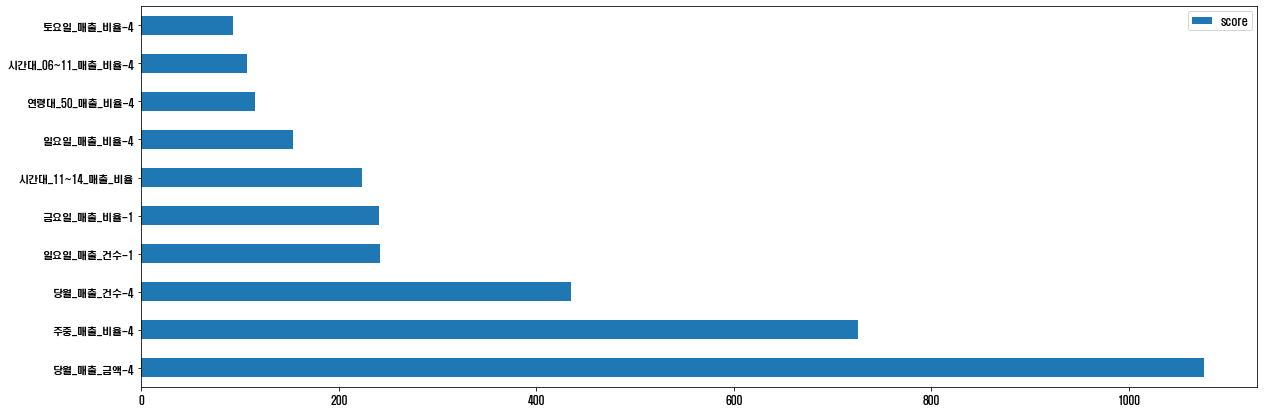

In [212]:
feature_important = xgb_5000_CS200007.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh')

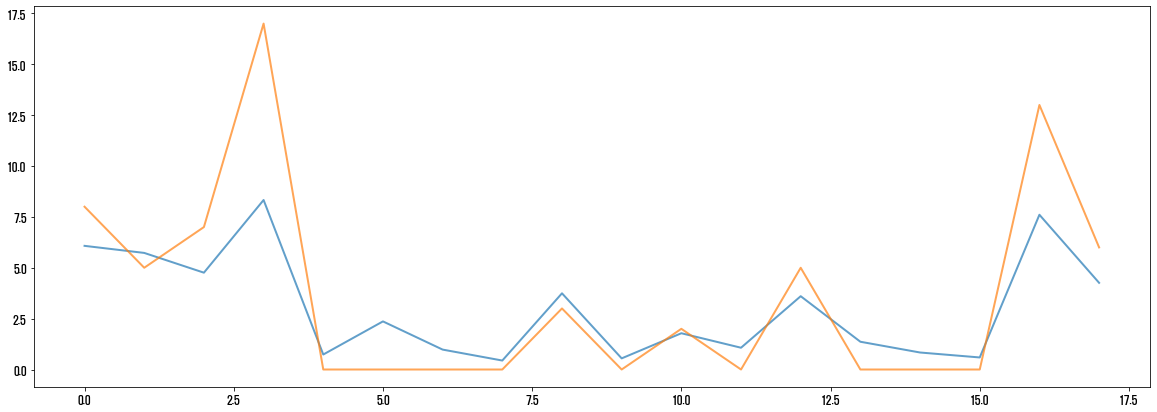

In [216]:
plt.pyplot.plot(xgb_5000_CS200007.predict(x_in_CS200007),alpha = 0.7,linewidth = 2)
# 파란색 : 예측값
# 주황색 : 실제값
# 갈색 : 파란색과 주황색이 겹치는 부분
plt.pyplot.plot(x_out_CS200007.values,alpha = 0.7,linewidth = 2)

In [ ]:
# ===================== 이하 모든 상권 대상 

In [3]:
def return_com_ba_by_year(year):
    if (year != 2020):
        common_ba = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,1))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,2))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,3))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,4))['상권_코드'])
    
    if (year == 2020):
        common_ba = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,1))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,2))['상권_코드'])
    
    return common_ba
    

In [4]:
# 모든 기간 공통 상권 코드를 구한다.

common_ba = set(return_com_ba_by_year(2020)) &\
set(return_com_ba_by_year(2019)) &\
set(return_com_ba_by_year(2018)) &\
set(return_com_ba_by_year(2017)) &\
set(return_com_ba_by_year(2016)) &\
set(return_com_ba_by_year(2015)) 

len(common_ba)

1483

In [5]:
def return_com_sc_by_year_and_ba(year,ba):
    if (year != 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,3,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,4,ba))['서비스_업종_코드_명'])
    
    if (year == 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])
    
    return common_sc

In [6]:
# 모든 기간 서비스업종 코드를 모아서 공통 서비스 업종 코드를 찾는다.

for ba in list(common_ba): # 1~1496
    globals()["common_sc_{}".format(ba)] = set(return_com_sc_by_year_and_ba(2020,ba)) &\
    set(return_com_sc_by_year_and_ba(2019,ba)) &\
    set(return_com_sc_by_year_and_ba(2018,ba)) &\
    set(return_com_sc_by_year_and_ba(2017,ba)) &\
    set(return_com_sc_by_year_and_ba(2016,ba)) &\
    set(return_com_sc_by_year_and_ba(2015,ba))
    
#     set(rev_2019.groupby(['상권_코드']).get_group((ba))['서비스_업종_코드_명'].tolist()) &\
#     set(rev_2018.groupby(['상권_코드']).get_group((ba))['서비스_업종_코드_명'].tolist()) &\
#     set(rev_2017.groupby(['상권_코드']).get_group((ba))['서비스_업종_코드_명'].tolist()) &\
#     set(rev_2016.groupby(['상권_코드']).get_group((ba))['서비스_업종_코드_명'].tolist()) &\
#     set(rev_2015.groupby(['상권_코드']).get_group((ba))['서비스_업종_코드_명'].tolist())            

In [8]:
common_ba

{1000001,
 1000002,
 1000003,
 1000004,
 1000005,
 1000006,
 1000007,
 1000008,
 1000009,
 1000010,
 1000011,
 1000012,
 1000013,
 1000014,
 1000015,
 1000016,
 1000017,
 1000018,
 1000019,
 1000020,
 1000021,
 1000022,
 1000023,
 1000024,
 1000025,
 1000026,
 1000027,
 1000028,
 1000029,
 1000030,
 1000031,
 1000032,
 1000033,
 1000034,
 1000035,
 1000036,
 1000037,
 1000038,
 1000039,
 1000040,
 1000041,
 1000042,
 1000043,
 1000044,
 1000045,
 1000046,
 1000047,
 1000048,
 1000049,
 1000050,
 1000051,
 1000052,
 1000053,
 1000054,
 1000055,
 1000056,
 1000057,
 1000058,
 1000059,
 1000060,
 1000061,
 1000062,
 1000063,
 1000064,
 1000065,
 1000066,
 1000067,
 1000068,
 1000069,
 1000070,
 1000071,
 1000072,
 1000073,
 1000074,
 1000075,
 1000076,
 1000077,
 1000078,
 1000079,
 1000080,
 1000081,
 1000082,
 1000083,
 1000084,
 1000085,
 1000086,
 1000087,
 1000088,
 1000089,
 1000090,
 1000091,
 1000092,
 1000093,
 1000094,
 1000095,
 1000096,
 1000097,
 1000098,
 1000099,
 1000100,


In [ ]:
# 각 년도별, 상권별 서비스 코드에서 상권별 공통된 서비스 코드는 구했고
# 이제 여기서 모든 상권에서 겹치는 서비스 코드를 구한다.
common_sc = set(common_sc_1000001)
for ba in list(common_ba): # 1~1496
    common_sc.intersection_update(globals()["common_sc_{}".format(ba))

    
    
common_sc 

In [7]:
new_rev_2020 = rev_2020.loc[rev_2020['상권_코드'].isin(common_ba)]
new_rev_2019 = rev_2019.loc[rev_2019['상권_코드'].isin(common_ba)]
new_rev_2018 = rev_2018.loc[rev_2018['상권_코드'].isin(common_ba)]
new_rev_2017 = rev_2017.loc[rev_2017['상권_코드'].isin(common_ba)]
new_rev_2016 = rev_2016.loc[rev_2016['상권_코드'].isin(common_ba)]
new_rev_2015 = rev_2015.loc[rev_2015['상권_코드'].isin(common_ba)]

In [ ]:
# new_rev_2015~2020 에 대해서 공통 sc만 남기고 합침

In [267]:
all_rev = new_rev_2020.append(new_rev_2019, ignore_index=True)\
.append(new_rev_2018, ignore_index=True)\
.append(new_rev_2017, ignore_index=True)\
.append(new_rev_2016, ignore_index=True)\
.append(new_rev_2015, ignore_index=True)

all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6415600,169,...,0,63,106,0,10,139,10,5,5,8
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,10400909742,5270,...,35,2458,2812,0,0,245,1441,1722,1862,5
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861756,2015,4,A,골목상권,1000295,장월로1길,CS200017,골프연습장,2441860,6,...,0,6,0,0,0,0,6,0,0,1
861757,2015,4,A,골목상권,1000488,신촌로12길,CS200041,사진관,1151515,12,...,0,12,0,0,12,0,0,0,0,3
861758,2015,4,A,골목상권,1000207,제기로5길,CS300002,편의점,479803060,98435,...,22128,62563,35668,5196,58253,17633,8113,7774,1263,3
861759,2015,4,A,골목상권,1000607,화곡로59길,CS200031,세탁소,48549293,3768,...,3,1938,1819,14,363,1088,990,1082,222,2
